In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os    
import math
from torchvision import transforms 
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from torch import nn
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from accelerate import Accelerator
from transformers import get_cosine_schedule_with_warmup
import itertools

### Diffusion Intuition


<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/diffusion.png?raw=true" width="800"/>
</div>

[Image Source](https://scholar.harvard.edu/binxuw/classes/machine-learning-scratch/materials/foundation-diffusion-generative-models)


Diffusion models are a powerful form for generative AI that intuitively works pretty easily! We first add noise to an image (forward diffusion process) and then learn how to remove noise from the image (backward diffusion process). Although we add random noise to the image, the noise is not added randomly! More specifically, the noise we add to an image follows a specific noise schedule. In modern diffusion models, there are a large variety of noise schedulers available, but they all do something similar, scheduling of the variance. Therefore, adding noise is easy and follows some rules but removing noise is hard and has to be learned!

The noise we add to the image is always gaussian noise, and a gaussian distribution is characterized by only two parameters, the mean $\mu$ and variance $\sigma^2$. When we sample nosie from this distribution, we assume the mean is 0, so we will be scheduling just the variance. I keep saying schedule but why is this? We don't actually add noise once, but multiple times! In most diffusion models today, we will add noise 1000 times to the image. By doing so, the original image will become essentially gaussian noise. The scheduler controls the intensity of noise at every step. If you have small variance, then the noise is very small, and if you have a large variance then the noise will be large. You could add the same amount of noise repeatedly to an image 1000 times but that may not be preferable. The scheduler can start by adding small amounts of noise that the beginning, and gradually increase the intensity of noise at every step. The reverse diffusion process then takes the noisy image, the number of times noise was added, and then attempts to remove the noise. 

A couple of really important clarifications before we go into the math though!

- If we add 500 steps of noise to an image, the model will attempt to reconstruct it back to the case where there was NO noise (the original image at step 0)
- During inference, we pass in **random noise** with the maximum timesteps of our model, lets pretend its 1000. Then the model will then remove as much noise as it can. We can then pass this denoised image with timestep of 999, and the model will attempt to denoise again. We take the denoised image again, pass it in with timestep 998, rinse and repeat!


Therefore **inferencing is slightly different than training**. When training, we are passing in actual images that have been destroyed with noise. But, even if we add noise to an image, the original image is still somewhere in there, just hidden away. When inferencing, we will only provide true noise, and the model attempts to create something from nothing. This is why we have repeated applications of the denoising model for all timesteps from 1000 down to 1. Even though the model was trained to undo all the timesteps of noise (if we pass in an image with 500 timesteps of noise go back to original image with 0 steps of noise), when the image is actually noise, we will have to reapply the denoising repeatedly to hopefully generate something useful!


### A Mathematical Overview to Understand Diffusion

There is a lot of interesting math that goes into diffusion, honestly it makes the statistician in me super excited! But there is quite a bit and some of it is nice to know, but there are more heavy details that are necessary to get a better grasp. There are things in the derivation that still don't make total sense to me so I will try to highlights some of the most important parts here! Lets break this up into chunks!

#### What are Generative Models? 

Generative models are learning something intuitively easy but in practce is an expensive process. Lets pretend we have an image $x$ and the collection of **ALL** possible images is $X$. Then our $x$ is a single sample from the population $X$. The purpose of a generative model is to learn the probability of $x$, written as the $p(x)$. If we learn this distribution, then we can sample from it to generate new samples! How we learn $p(x)$ changes based on which method we use. 

#### Forward Diffusion

Forward diffusion is the process of iteratively adding noise to data according to some variance schedule for $T$ timesteps. We will identify the forward process with the variable $q$ which will identify the conditional distribution of some noise image $X_T$ given the original image $X_0$. We can then write all the steps $1,...T$ of noise as the following!

$$q(x_{1:T}|x_0) = \prod_{t=1}^Tq(x_t|x_{t-1})$$

As you can see, we are just multiplying every consecutive pairs of timesteps together to get our full probability distribution of all the timesteps together. The original DDPM paper then says that we can write a single one of these consecutive timestep probabilities as follows:

$$q(x_t|x_{t-1}) = N(x_t;\sqrt{1-B_t}x_{t-1}, B_t)$$

where $B_1, B_2, ..., B_T$ is a fixed noise schedule for the variance. 

Basically, $x_t$ should be sampled from a normal distribution with a mean centered at $\sqrt{1-B_t}x_{t-1}$, based on the previous timestep, and variance of $B_t$. But where did this even come from? At every step we add some noise, but if we dont scale the x down as we add noise we will have a variance explosion, therefore we can do this proof:


***Proof***

Let $x_0 \sim N(\mu, 1)$, so it has some arbritary mean and a variance of 1. We want to add noise to the image $x_0$ but **ALWAYS KEEP THE VARIANCE AT 1** to avoid any variance explosions. Lets pretend our nosie is just randomly sampled from a standard normal distribution:

$$\epsilon \sim N(0,1)$$

To compute $x_1$ we will scale $x_0$ by some unknown factor $a$ and scale the added noise by another unknown factor $b$. Therefore we can write it as:

$$x_1 = ax_0 + b\epsilon$$

Now a quick review of normal distributions! If we multiply a normal distribution by some constant what happens?

$$Var(aX) = a^2Var(x)$$

Remember again, our variance scheduler determines the amount of noise added at every step, but currently the noise is just standard normal, but we want $\epsilon_1$ to have variance $B_1$. That should be easy enough to do because of the variance product rule! If $\epsilon_1$ has variance 1, then:

$$Var(\sqrt{B_1}\epsilon_1) = (\sqrt{B_1})^2Var(\epsilon_1) = B_1 * 1 = B_1$$

So now we know in our equation $x_1 = ax_0 + b\epsilon$ that b should be $\sqrt{B_1}$, so we can write our first step out as:

$$x_1 = ax_0 + \sqrt{B_1}\epsilon$$

Now the second condition! We want to make sure that $x_1$ has an overall variance of 1 at the end to avoid variance explosions, so we can compute a to make that happen. 

$$Var(x_1) = Var(ax_0 + \sqrt{B_1}\epsilon) = Var(ax_0) + Var(\sqrt{B_1}\epsilon)$$

Again remember, $x_0$ has a variance of 1 and $\epsilon$ also has a variance of 1, so by the variance rule we can compute:

$$Var(x_1) = a^2Var(x_0) + B_1Var(\epsilon) = a^2 + B_1$$

This variance then has to have a sum of 1, so we can solve for a,

$$a^2 + B_1 = 1 \text{  therefore  } a = \sqrt{1 - B_1}$$

Therefore we have:

$$x_1 = \sqrt{1-b_1}x_0 + \sqrt{B_1}\epsilon$$

and we can write the more general form for an arbritrary $t$:

$$x_t = \sqrt{1-b_t}x_{t-1} + \sqrt{B_t}\epsilon$$

Which can also be written as $q(x_t|x_{t-1}) = N(x_t;\sqrt{1-B_t}x_t, B_t)$

So first things first, we need a list of numbers to be our schedule for noise! There are a ton of schedulers out there (linear, cosine, etc...) so lets just go with a simple linear scheduler:


#### Linear Scheduler 
```python
beta_start = 0.0001
beta_end = 0.2
num_training_steps = 1000
beta_schedule = torch.linspace(beta_start, beta_end, num_training_steps)
```

***Adding Efficiency***

So we have made it back to our original equation! But we still have a problem, which has more to do with practical efficiency rather than theory. If we want an image with 500 steps of noise added to it, we actually need to do a for loop to repeatedly add noise, but would't it be nice to be able to add all 500 steps of noise in just a single calculation? We are just adding gaussian noise over and over to an image, and we know the sum of gaussians are also a gaussian, so we should be able to do this. 


In the paper they do this by introducing a new variable that is just a manipulation of our old variable $B_t$

$$a_t = 1 - B_t \text{ and } \bar{a}_t = \prod_{s=1}^t\alpha_s$$

for example:

$$\bar{a}_2 = a_1 * a_2 = (1-B_1)*(1-B_2)$$

We can go ahead and compute these pieces as well then!

#### Alpha Computation 
```python

### Compute Alpha ###
alpha = 1 - beta_schedule

### Compute Cumulative Alpha ###
alpha_cumulative_prod = torch.cumprod(alpha)
```

So time for some fun algebraic manipipulations! Rember our previous eqation for $x_t$?

$$x_t = \sqrt{1-b_t}x_{t-1} + \sqrt{B_t}\epsilon$$

Lets rewrite this in terms of our new variable $a_t$

$$x_t = \sqrt{a_t}x_{t-1} + \sqrt{1 - a_t}\epsilon$$

Well $x_{t-1}$ can be written very similarly:

$$x_{t-1} = \sqrt{a_{t-1}}x_{t-2} + \sqrt{1-a_{t-1}}\epsilon$$

Lets substitute $x_{t-1}$ into our formula for $x_t$
$$x_t = \sqrt{a_t} [ \sqrt{a_{t-1}}x_{t-2} + \sqrt{1-a_{t-1}}\epsilon]  + \sqrt{1 - a_t}\epsilon$$

$$= \sqrt{a_t}\sqrt{a_{t-1}}x_{t-2} + \sqrt{a_t}\sqrt{1 - a_{t-1}}\epsilon + \sqrt{1 - a_t}\epsilon$$

Now how can we simplify this? This was probably one of the tricker parts of the derivation that I didn't catch at first glance! Remember again, $\epsilon$ is just a random variable coming from a standard normal distribution, and by multiplying it by some constant, we are adjusting its variance. We have two parts of our equation above using epsilon, so lets try to combine them! Therefore lets create some temporary random variables using our variance rule from earlier:

$$\sqrt{a_t}\sqrt{1 - a_{t-1}}\epsilon = X \sim N(0, a_t(1 - a_{t-1}))$$
$$\sqrt{1 - a_t}\epsilon = Y \sim N(0, 1 - a_t)$$

Therefore $X$ and $Y$ are both normal distributions with different variances. So a quick review, what happens when we add two normal distributions together with different means and variances?

$$N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1+\mu_2, \sigma_1^2+\sigma_2^2)$$

So similarly, lets add together our two normal distributions $X$ and $Y$ above.

$$X + Y = N(0, a_t(1 - a_{t-1})) + N(0, 1 - a_t) = N(0, a_t(1 - a_{t-1}) + (1 - a_t))$$
$$= N(0, 1 - a_ta_{t-1})$$

Again by the variance rule we can write this normal distribution as the standard normal epsilon, multiplied by the sqrt of the variance we want!

$$N(0, 1 - a_ta_{t-1}) = \sqrt{1 - a_ta_{t-1}}\epsilon$$

Therefore our final equation for $x_t$ can be written as:

$$x_t = \sqrt{a_t}\sqrt{a_{t-1}}x_{t-2} + (\sqrt{1 - a_ta_{t-1}})\epsilon$$

Now what if we substituted in the equation for $x_{t-2}$ like we did earlier for $x_{t-1}$? Well the same thing! Actually we can continue substituting repeatedly and you will see a pattern emerge that, 

$$q(x_t|x_0) = \prod_{i=1}^t\sqrt{a_i}x_0 + (\sqrt{1 - \prod_{i=1}^ta_i})\epsilon$$

Which is then written with the shorthand $\bar{a}_t$ notation. 

$$q(x_t|x_0) = \sqrt{\bar{a}_t}x_0 + (\sqrt{1 - \bar{a}_t})\epsilon$$

So we did it! If you made it this far, you should now understand all the details about the forward diffusion process and ways we can make it more efficient! Lets do a quick implementation of the formulas above:

```python

### What is the image we want to add noise to ? ###
x_0 = IMAGE

### What is the timestep we want? Lets add 500 steps of noise ###
timestep = 500

### Grab the corresponding cumulative alpha for 500 steps of noise ###
alpha_bar_t = alpha[timestep]

### Compute Mean Coefficient ###
mean_coeff = alpha_bar_t ** 0.5

### Compute Variance Coefficient ###
var_coeff = (1 - alpha_bar_t) ** 0.5

### Generate some Random Noise for the Episilon ###
epsilon = torch.randn(x_0.shape)

### Use the reparamaterization trick to sample from distribution ###
noisy_image = mean_coef*inputs + var_coef*epsilon


```


#### Backward Diffusion

Forward diffusion is not too bad! Basically we have a scheduler, so we know the sequence of gaussian distributions we want to sample noise from, and we iteratively add steps of noise to our image! On the other hand, how do we undo the steps of noise? Unfortunately, this is much harder and we will have to use a Neural Network to approximate this. Lets write out this with some math again where we want to represent, what is the distribution of the removal of $T$ steps of noise?

$$P_\theta(x_{0:T}) = P(X_T)\prod_{t=1}^TP_\theta(X_{t-1}|x_t)$$

Notice the conditional $P_\theta(X_{t-1}|x_t)$, we want the previous timestep given a future one, which is backwards from the forward diffusion process. We can represent this probability as the following:

$$P(X_T)\prod_{t=1}^TP_\theta(X_{t-1}|x_t) \sim N(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t,t))$$

where $\mu_\theta(x_t, t), \Sigma_\theta(x_t,t)$ have to be learned by the neural network! Again we have no idea what these reverse probability distributions are. But what was the original problem we want to solve? We want to compute $P(x_0)$, the distribution of the original image data. But right now we will have the joint distribution of $P_\theta(x_{0:T})$ which means we need to marginalize our distribution. If you don't know what marginalizaing a distribution means just take a quick look [here](https://en.wikipedia.org/wiki/Marginal_distribution). At a high level, if you have a joint distribution in two variables, and you only want one of them, you can integrate out the ones that you dont. In our case it will look something like this:

$$P(x_0) = \int_{x_1}\int_{x_2}\int_{x_3}...\int_{x_T} P(x_{0:T})dx_1dx_2...dx_T$$

This would be an incredibly expensive process though so instead we will take a hint from Variational AutoEncoders and use the *Evidence Lower Bound*. The mathematical derivation is out of the scope of gathering some intuition for diffusion models as I try to push a more hands-on approach than a theory driven one. I was writing the derivation out myself when making this tutorial and then I found an incredible resource! Author Lilian Weng has this great blog post [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) where it covers all the ground level math for you to really know the reverse process. Definitely give it a read, you will need to know a bit about ELBO and Bayes rule to do it but it should be pretty intuitive! In our case, lets just go over the results of the reverse diffusion process rather than the derivation. This was the given recipie by the original DDPM paper.


First we will have a small change in the forward diffusion process. Uptil now, we have been doing forward diffusion as $q(x_t|x_{t-1})$. Instead, we will also condition $x_t$ on $x_0$, so it will look like $q(x_t|x_{t-1}, x_0)$. We can then use Bayes rule to get an expression for $q(x_{t-1}|x_t, x_0)$. The reason for this is, if you do the derivation, you will see that the reverse conditional probability actually isn't possible to solve without conditioning on $x_0$. This is the first main derivation showed in Lilian Weng's blog post that you can look at! But the result is:

$$q(x_{t-1}|x_t, x_0) \sim N(x_{t-1}; \tilde{\mu}(x_t, x_0), \Sigma_\theta(x_t,t))$$

We can then write $\tilde{\mu}_t$ as:

$$\tilde{\mu}_t = \frac{1}{\sqrt{a_t}}(x_t - \frac{1-a_t}{\sqrt{1-\bar{a_t}}}e_t)$$

and our full expression for $q(x_{t-1}|x_t, x_0)$ becomes:

$$q(x_{t-1}|x_t, x_0) \sim N(x_{t-1}; \frac{1}{\sqrt{a_t}}(x_t - \frac{1-a_t}{\sqrt{1-\bar{a_t}}}e_t), \Sigma_\theta(x_t,t))$$

In the original DDPM paper **ONLY** the mean of the reverse process is learned, $\mu_\theta$ and the variance $\Sigma_t$ is fixed according to the scheduler. So we can then set $\Sigma_\theta(x_t,t) to \sigma_t^2I$. In later papers like the [Improved Diffusion Models](https://openreview.net/pdf?id=-NEXDKk8gZ) paper, the model will learn both the mean and variance of the reverse process. Because $\sigma_t^2I$ is set ahead of time, we can directly compute it! The paper sets this as:

$$\sigma_t^2I = \frac{1-\bar{a}_{t-1}}{1-\bar{a}_{t}}B_t$$

We could also have done $\sigma_t^2I = B_t$ and directly used our beta schedule only but the DDPM paper found no difference experimentally between using one or the other, so we will just go with the previous expression as its typically used in implementations I've seen!

So our final form of the reverse process is:

$$q(x_{t-1}|x_t, x_0) \sim N(x_{t-1}; \frac{1}{\sqrt{a_t}}(x_t - \frac{1-a_t}{\sqrt{1-\bar{a_t}}}e_t), \sigma_t^2I)$$

I know I skipped over a ton of mathematical detail again, maybe later I'll make a deeper dive into the reverse process! But for now this should be enough to get started.

Lets quickly look at the simplified code that will compute all of this! There are three things we need, the noisy image, what timestep we are on, and the predicted noise. 

```python

### Pass in the things we need ###
timestep = 500
noisy_image = NOISY_IMAGE
predicted_noise = PREDICTED_NOISE

### Compute Sigma (b_t * (1 - cumulative_a_(t-1)) / (1 - cumulative_a)) * noise ###
alpha_bar_t = alpha_cumulative_prod[timestep]
alpha_bar_t_prev = alpha_cumulative_prod[timestep - 1]
beta_t = beta_schedule[timestep]
noise = torch.randn_like(input)
variance = beta_t * (1 - alpha_cumulative_prod_t_prev) / (1 - alpha_cumulative_t)
sigma = noise * variance**0.5

### Compute Noise Coefficient (1 - a_t / sqrt(1 - cumulative_a)) where 1 - a_t = b_t ###
beta_t = beta_schedule[timestep]
alpha_bar_t = alpha_cumulative_prod[timestep]
root_one_minus_alpha_bar_t = (1 - alpha_bar_t) ** 0.5
noise_coefficient = beta_t / root_one_minus_alpha_bar_t

### Compute 1 / sqrt(a_t) ###
reciprocal_root_a_t = (alpha[timestep]**-0.5)

### Compute Denoised Image ###
denoised = reciprocal_root_a_t * (noisy_image - (noise_coefficient * predicted_noise)) + sigma_z

```

### How do we learn this?

As you can see, the entire problem now boils down to, given an image that is noisy, predict the noise so we can remove it! The DDPM paper states that we can then  take an image, predict the noise, and use Mean Squared Error as our loss function between the predicted and true noise. In practice though you could also use Mean Absolute Error or the Huber Loss (L1 + L2 Error). There are some mathematical justifications for this too. If you think back to Variational Autoencoders, what are trying to do is to maximize the Evidence Lower Bound (ELBO) because learning the likelihood of the data generating distribution is impossible, but we can learn the minmum bound of that function and continue to maximize it. The reason we are not taking a similar approach here is, the authors of DDPM claim that as long as the steps of noise added to the image is sufficiently small, we can approximate it with Mean Squared Error. You can take a closer look [here](https://jaketae.github.io/study/elbo/) if you want to see more!

### Define Sampler ###

We will now take everything we say previously and put it all together to create our scheduler! There are again a lot of different schedulers that exist, but for now we will stick to the basis linear beta scheduler! Again, at a high level, the sampler will have two methods:
- **add_noise** will take an image and add some timesteps amount of noise to it
- **remove_noise** will take a noisy image, which timestep of noise it was at, and the models predicted noise and remove the noise accoring the scheduling parameters

The other change that will be made from the pseudocode before is we need to make sure out adding/removing noise can be applied to batches of images, and can occur on the correct device if it isn't running on the CPU!

In [2]:
class Sampler:
    def __init__(self, num_training_steps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_training_steps = num_training_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        ### Define Basic Beta Scheduler ###
        self.beta_schedule = self.linear_beta_schedule()

        ### Compute Alphas for Direction 0 > t Noise Calculation ###
        self.alpha = 1 - self.beta_schedule
        self.alpha_cumulative_prod = torch.cumprod(self.alpha, dim=-1)
    
    def linear_beta_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.num_training_steps)

    def _repeated_unsqueeze(self, target_shape, input):
        while target_shape.dim() > input.dim():
            input = input.unsqueeze(-1)
        return input
    
    def add_noise(self, inputs, timesteps):

        batch_size, c, h, w = inputs.shape

        ### Grab the Device we want to place tensors on ###
        device = inputs.device
        
        alpha_cumulative_prod_timesteps = self.alpha_cumulative_prod[timesteps].to(device)
        
        ### Compute Mean Coefficient ###
        mean_coeff = alpha_cumulative_prod_timesteps ** 0.5

        ### Compute Variance Coefficient ###
        var_coeff = (1 - alpha_cumulative_prod_timesteps) ** 0.5

        ### Reshape mean_coeff and var_coeff to have shape (batch x 1 x 1 x 1) so we can broadcast with input (batch x c x height x width) ###
        mean_coeff = self._repeated_unsqueeze(inputs, mean_coeff)
        var_coeff = self._repeated_unsqueeze(inputs, var_coeff)

        ### Generate some Noise X ~ N(0,1) (rand_like will automatically place on same device as the inputs) ###
        noise = torch.randn_like(inputs)
        
        ### Compute Mean (mean_coef * x_0) ###
        mean = mean_coeff * inputs

        ### Compute Variance ###
        var = var_coeff * noise

        ### Compute Noisy Data ###
        noisy_image = mean + var

        return noisy_image, noise
        
    def remove_noise(self, input, timestep, predicted_noise):

        assert (input.shape == predicted_noise.shape), "Shapes of noise pattern and input image must be identical!!"
        
        b, c, h, w = input.shape

        ### Grab Device to Place Tensors On ###
        device = input.device

        ### Create a mask (if timestep == 0 sigma_z will also be 0 so we need to save this for later ###
        greater_than_0_mask = (timestep >= 1).int()

        
        ### Compute Sigma (b_t * (1 - cumulative_a_(t-1)) / (1 - cumulative_a)) * noise ###
        alpha_cumulative_t = self.alpha_cumulative_prod[timestep].to(device)
        alpha_cumulative_prod_t_prev = self.alpha_cumulative_prod[timestep - 1].to(device) # (timestep - 1) if timestep is 0 is WRONG! we will multiply by 0 later
        beta_t = self.beta_schedule[timestep].to(device)
        noise = torch.randn_like(input)
        variance = beta_t * (1 - alpha_cumulative_prod_t_prev) / (1 - alpha_cumulative_t)

        ### 0 out the variance for if the timestep == 0 ###
        variance = variance * greater_than_0_mask
        variance = self._repeated_unsqueeze(input, variance)
        sigma_z = noise * variance**0.5

        ### Compute Noise Coefficient (1 - a_t / sqrt(1 - cumulative_a)) where 1 - a_t = b_t ###
        beta_t = self.beta_schedule[timestep].to(device)
        alpha_cumulative_t = self.alpha_cumulative_prod[timestep].to(device)
        root_one_minus_cumulative_alpha_t = (1 - alpha_cumulative_t) ** 0.5
        noise_coefficient = beta_t / root_one_minus_cumulative_alpha_t
        noise_coefficient = self._repeated_unsqueeze(input, noise_coefficient)
        

        ### Compute 1 / sqrt(a_t) ###
        reciprocal_root_a_t = (self.alpha[timestep]**-0.5).to(device)
        reciprocal_root_a_t = self._repeated_unsqueeze(input, reciprocal_root_a_t)
        
        ### Compute Denoised Image ###
        denoised = reciprocal_root_a_t * (input - (noise_coefficient * predicted_noise)) + sigma_z
 
        return denoised

### Lets Test our Scheduler! 

For this, we need a sample image, transformations to go from images to tensors, and to go back to images from tensors. For the transformations, we will make use of the ones give in the [Huggingface Annotated Diffusion](https://huggingface.co/blog/annotated-diffusion)!

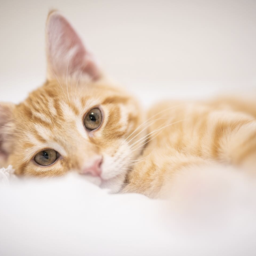

In [3]:
### Define an Image Size ###
image_size = 256

### Load Image ###
image = Image.open("src/sample_image.png").convert("RGB")

### Init Sampler ###
sampler = Sampler()

### Transformations ###
image2tensor_transform = transforms.Compose([
                    transforms.Resize((image_size, image_size)), # Resize Image
                    transforms.ToTensor(), # Convert to tensor (will scale from 0 to 1)
                    transforms.Lambda(lambda t: (t*2) - 1), # Change scale to be -1 to 1
                    transforms.Lambda(lambda t: t.unsqueeze(0))
])

tensor2image_transform = transforms.Compose([
        transforms.Lambda(lambda t: t.squeeze(0)), # Remove batch dimension on
        transforms.Lambda(lambda t: (t + 1) / 2), # Scale back to 0 to 1
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # Make channels last 
        transforms.Lambda(lambda t: t * 255.), # Scale back to 0 to 255
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert to numpy
        transforms.ToPILImage(), # Conver to PIL
    ])


### Check Transforms ###
tensor2image_transform(image2tensor_transform(image))


### Define Model

We can now define the structure of the model. The parts are:

#### **SelfAttention, MLP, and TransformerBlock** 

if this seems weird to you take a look at my [Vision Transformer](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Computer%20Vision/Vision%20Transformer) tutorial where we look really closely at the attention mechanism!

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/att_mat.png?raw=true" width="800"/>
</div>

In [4]:
class SelfAttention(nn.Module):

  def __init__(self,
               in_channels,
               num_heads=12, 
               attn_p=0,
               proj_p=0,
               fused_attn=True):

    super().__init__()
    assert in_channels % num_heads == 0
    self.num_heads = num_heads
    self.head_dim = int(in_channels / num_heads)
    self.scale = self.head_dim ** -0.5
    self.fused_attn = fused_attn  

    self.qkv = nn.Linear(in_channels, in_channels*3)
    self.attn_p = attn_p
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(in_channels, in_channels)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    batch_size, seq_len, embed_dim = x.shape
      
    qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
    qkv = qkv.permute(2,0,3,1,4)
    q,k,v = qkv.unbind(0)

    if self.fused_attn:
      x = F.scaled_dot_product_attention(q,k,v, dropout_p=self.attn_p)
    else:
      attn = (q @ k.transpose(-2,-1)) * self.scale
      attn = attn.softmax(dim=-1)
      attn = self.attn_drop(attn)
      x = attn @ v
    
    x = x.transpose(1,2).reshape(batch_size, seq_len, embed_dim)
    x = self.proj(x)
    x = self.proj_drop(x)
    
    return x

class MLP(nn.Module):
    def __init__(self, 
                 in_channels,
                 mlp_ratio=4, 
                 act_layer=nn.GELU,
                 mlp_p=0):

        super().__init__()
        hidden_features = int(in_channels * mlp_ratio)
        self.fc1 = nn.Linear(in_channels, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(mlp_p)
        self.fc2 = nn.Linear(hidden_features, in_channels)
        self.drop2 = nn.Dropout(mlp_p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x
        
class TransformerBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 fused_attention=True,
                 num_heads=4, 
                 mlp_ratio=2,
                 proj_p=0,
                 attn_p=0,
                 mlp_p=0,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        
        super().__init__()
        self.norm1 = norm_layer(in_channels, eps=1e-6)

        self.attn = SelfAttention(in_channels=in_channels,
                                  num_heads=num_heads, 
                                  attn_p=attn_p,
                                  proj_p=proj_p,
                                  fused_attn=fused_attention)
        
        self.norm2 = norm_layer(in_channels, eps=1e-6)
        self.mlp = MLP(in_channels=in_channels,
                       mlp_ratio=mlp_ratio,
                       act_layer=act_layer,
                       mlp_p=mlp_p)
        
    def forward(self, x):
        batch_size, channels, height, width = x.shape
      
        ### Reshape to batch_size x (height*width) x channels
        x = x.reshape(batch_size, channels, height*width).permute(0,2,1)
        
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        x = x.permute(0,2,1).reshape(batch_size, channels, height, width)
        return x

rand_img = torch.randn(4,32,64,64)
t = TransformerBlock(in_channels=32)
t(rand_img).shape

torch.Size([4, 32, 64, 64])

#### Sinusoidal Time Embeddings 

The model needs to have some idea of "time". In this case, it will be, what timestep of noise am I at? To do so, we can directly use sinusoidal time embeddings proposed in the [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper. If you haven't seen this before, here is a super high level overview. The formula for the embeddings is as follows:

$$PE_{position, 2i} = sin(\frac{position}{10000^{2i/d_{model}}})$$
$$PE_{position, 2i+1} = cos(\frac{position}{10000^{2i+1/d_{model}}})$$

The position in our case is the **timestep** (for the 1000 timesteps of noise we want to have) and $d_{model}$ is actually a hyperparameter in this case. If you remember back to Language models, we actually know $d_{model}$ ahead of time, the length of the vectors we use to represent tokens. We do know it here, but the embedding depth will change, because if you again think about how typical Convolutional models work, as we go deeper into the model we will have **more channels**. So at the beginning, we may only have 64 channels, so the $d_{model}$ is 64, but later we may have 512 channels, so then the $d_{model}$ is 512. Therefore we will create time embeddings for now for some given length $d_{model}$, and then expand as needed in the later architecture!

The index $i$ refers to, which index are we accessing in the $d_{model}$. Technically we should be interleaving $sin$ and $cos$ for every even and odd index ($2i$ and $2i+1$), but experimentally I dont think it matters if we take all our our even sin values and then just concatenate all the odd cos values, so we will just do that to keep it easy!

We can then use linear layers to pick the length of these vectors, so we can pass in two hyperparameters **time_embed_dim**, which will be the initial dimension of our time embeddings and **scaled_time_embed_dim**, which will be the size of the projected time embed dim after some linear layers. We will also use the **SiLU** activation function for no reason other than thats what I've seen online!

In [5]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, time_embed_dim, scaled_time_embed_dim):
        super().__init__()
        self.inv_freqs = nn.Parameter(1.0 / (10000 ** (torch.arange(0, time_embed_dim, 2).float() / (time_embed_dim/2))), requires_grad=False)
        
        self.time_mlp = nn.Sequential(nn.Linear(time_embed_dim, scaled_time_embed_dim), 
                                      nn.SiLU(), 
                                      nn.Linear(scaled_time_embed_dim, scaled_time_embed_dim), 
                                      nn.SiLU())
    def forward(self, timesteps):
        timestep_freqs = timesteps.unsqueeze(1) * self.inv_freqs.unsqueeze(0)
        embeddings = torch.cat([torch.sin(timestep_freqs), torch.cos(timestep_freqs)], axis=-1)
        embeddings = self.time_mlp(embeddings)
        return embeddings

s = SinusoidalTimeEmbedding(time_embed_dim=128,scaled_time_embed_dim=256)
timesteps = torch.tensor([1,2,3])
s(timesteps).shape

torch.Size([3, 256])

#### **UNet, Residual Blocks, Upsample Blocks** 

Our implementation of UNets will be pretty similar to the UNet proposed except for one key difference! In the original UNet, the upsampling (decoder) was done through a series of Transpose Convolutions. Transpose Convolutions are fine for image segmentation, but when it comes to image generation it can lead to a problem known as a checkerboard effect. You can see some cool examples of this [here!](https://distill.pub/2016/deconv-checkerboard/). At a high level, transpose conovolutions sometimes can overlap more in some areas of an image than another, do during generation, it will put more emphasis in specific locations of an image than other parts. This leads to darker or more saturated chunks in the image leading to the checkerboard pattern. In practice, using a simple Upsampling method like nearest neighbors or linear interpolation followed by a regular convolution works best so thats what we will do!

This implementation is also more for teaching, and we will be dynamically defining the structure of the model before building the layers so you can see how it comes together!

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/Unet.png?raw=true" width="800"/>
</div>


**Sidenote**

We will be utilizing a method known as GroupNorm in this archietcture. 

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/dl_normalizations.png?raw=true" width="800"/>
</div>

[source](https://arxiv.org/pdf/1803.08494.pdf)

Layernorm that we have been using for transformers normalize across all channels (in this case normalize across all channels of our image). Groupnorm will chunk across channels so each block of channels are normalized. This in practice gives better location specific normalization and can be used instead of layernorm or batchnorm!

#### Lets Start with the first piece, ResidualBlocks!

The **ResidualBlock** will be a block of convolutions, normalizations and where we incorporate our time embeddings intot he model. The crucial part of our residual block is **NO UPSAMPLING OR DOWNSAMPLING SHOULD OCCUR**. The shape of image (image shape and number of channels) that go into the ResidualBlock must come out identically! And you may be wondering, how do we incorporate time embeddigs? Time embeddings are a vector, but our image is a 3d tensor? Easy! We just reshape, broadcast and add it together! Lets just look at that piece first. 

In [6]:
batch_size = 4

### Create some random images with 64 channels, and size of 32 by 32 ###
random_image = torch.randn(batch_size, 64, 32, 32)
print("Image Tensor", random_image.shape)

### Our random images have 64 channels, so our embeddings need to have a d_model of 64 ###
random_time_embeddings = torch.randn(batch_size, 64)
print("Original Time Embeddings", random_time_embeddings.shape)

### To add together a (b, 64, 32, 32) with a (b, 64) we need to add some extra dimensions to our embeddings ###
random_time_embeddings = random_time_embeddings.unsqueeze(-1).unsqueeze(-1)
print("Reshaped Time Embeddings", random_time_embeddings.shape)

## Add them together! ##
timed_images = random_image + random_time_embeddings
print("Output", timed_images.shape)

Image Tensor torch.Size([4, 64, 32, 32])
Original Time Embeddings torch.Size([4, 64])
Reshaped Time Embeddings torch.Size([4, 64, 1, 1])
Output torch.Size([4, 64, 32, 32])


One thing to keep in mind though is, our random_time_embeddings had exactly the number of channels we needed. In our case, we need to make sure to resize the original output from our **SinusoidalTimeEmbeddings** to match our required channels. Lets put it together!

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groupnorm_num_groups, time_embed_dim):
        super().__init__()
        
        ### Time Embedding Expansion to Out Channels ###
        self.time_expand = nn.Linear(time_embed_dim, out_channels)

        ### Input Convolutions + GroupNorm ###
        self.groupnorm_1 = nn.GroupNorm(groupnorm_num_groups, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")

        ### Input + Time Embedding Convolutions + GroupNorm ###
        self.groupnorm_2 = nn.GroupNorm(groupnorm_num_groups, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")

        ### Residual Layer ###
        self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_embeddings):

        residual_connection = x

        ### Time Expansion to Out Channels ###
        time_embed = self.time_expand(time_embeddings)
        
        ### Input GroupNorm and Convolutions ###
        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)

        ### Add Time Embeddings ###
        x = x + time_embed.reshape((*time_embed.shape, 1, 1))

        ### Group Norm and Conv Again! ###
        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)

        ### Add Residual and Return ###
        x = x + self.residual_connection(residual_connection)
        
        return x
        

#### Upsampling 

The next step is easy! Like we had seen before, we just want to do a regular upsample using any type of interpolation by a factor of 2, and then use a convolutional layer afterwards that will return the same size as the upsampled image!.

In [8]:
class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        )

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        upsampled = self.upsample(inputs)
        assert (upsampled.shape == (batch, channels, height*2, width*2))
        return upsampled

#### Building the UNet

This is probably the hardest part, especially for someone who hasn't made a UNet before. Lets take it a piece at a time! The things we need to let our UNet know are:

- **in_channels**: How many input channels does our input image have? Probably 3 if RGB
- **start_dim**: What is the starting dimension of the first convolution projection? There will be 3 channels into the first convolution, but how many channels do you want out? This should be 128 for a good model, but we will keep it 64 so its not too big and you can train it!
- **dim_mults**: A tuple of expansion factors. For example if our start_dim is 64 and the dim_mults are (1,2,4), then the number of channels in the following conovlution blocks will be (64\*1, 64\*2, 64\*4). Therefore our final output of the encoder will be 256. The decoder will also use the dim mults but in reverse order. Meaning it will start at 64\*4 and work its way back to 64\*1.
- **residual_blocks_per_group**: After every down or upsample, we can repeat Residual blocks (which dont change any shape) multiple times to have more parameters in our model
- **time_embed_dim**: What is the expected time embedding size from our SinusoidalTimeEmbeddings

#### Here is a high level overview of some of the specifics of the UNet architecture!

For this drawing, we will only use 1 residual blocks per group just to keep it simple!

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/my_unet.png?raw=true" width="800"/>
</div>



In [9]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, start_dim=64, dim_mults=(1,2,4), residual_blocks_per_group=1, groupnorm_num_groups=16, time_embed_dim=128):
        super().__init__()

        #######################################
        ### COMPUTE ALL OF THE CONVOLUTIONS ###
        #######################################
        
        ### Store Number of Input channels from Original Image ###
        self.input_image_channels = in_channels
        
        ### Get Number of Channels at Each Block ###
        channel_sizes = [start_dim*i for i in dim_mults]
        starting_channel_size, ending_channel_size = channel_sizes[0], channel_sizes[-1]

        ### Compute the Input/Output Channel Sizes for Every Convolution of Encoder ###
        self.encoder_config = []
        
        for idx, d in enumerate(channel_sizes):
            ### For Every Channel Size add "residual_blocks_per_group" number of Residual Blocks that DONT Change the number of channels ###
            for _ in range(residual_blocks_per_group):
                self.encoder_config.append(((d, d), "residual")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels x Height x Width)

            ### After Residual Blocks include Downsampling (by factor of 2) but dont change number of channels ###
            self.encoder_config.append(((d,d), "downsample")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels x Height/2 x Width/2)

            ### Compute Attention ###
            self.encoder_config.append((d, "attention"))
            
            ### If we are not at the last channel size include a channel upsample (typically by factor of 2) ###
            if idx < len(channel_sizes) - 1:
                self.encoder_config.append(((d,channel_sizes[idx+1]), "residual")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels*2 x Height x Width)
            
        ### The Bottleneck will have "residual_blocks_per_group" number of ResidualBlocks each with the input/output of our final channel size###
        self.bottleneck_config = []
        for _ in range(residual_blocks_per_group):
            self.bottleneck_config.append(((ending_channel_size, ending_channel_size), "residual"))

        ### Store a variable of the final Output Shape of our Encoder + Bottleneck so we can compute Decoder Shapes ###
        out_dim = ending_channel_size

        ### Reverse our Encoder config to compute the Decoder ###
        reversed_encoder_config = self.encoder_config[::-1]

        ### The output of our reversed encoder will be the number of channels added for residual connections ###
        self.decoder_config = []
        for idx, (metadata, type) in enumerate(reversed_encoder_config):
            ### Flip in_channels, out_channels with the previous out_dim added on ###
            if type != "attention":
                enc_in_channels, enc_out_channels = metadata
            
                self.decoder_config.append(((out_dim+enc_out_channels, enc_in_channels), "residual"))
                        
                if type == "downsample":
                    ### If we did a downsample in our encoder, we need to upsample in our decoder ###
                    self.decoder_config.append(((enc_in_channels, enc_in_channels), "upsample"))
    
                ### The new out_dim will be the number of output channels from our block (or the cooresponding encoder input channels) ###
                out_dim = enc_in_channels
            else:
                in_channels = metadata
                self.decoder_config.append((in_channels, "attention"))

        ### Add Extra Residual Block for residual from input convolution ###
        # hint: We know that the initial convolution will have starting_channel_size
        # and the output of our decoder will also have starting_channel_size, so the
        # final ResidualBlock we need will need to go from starting_channel_size*2 to starting_channel_size

        self.decoder_config.append(((starting_channel_size*2, starting_channel_size), "residual"))
        
        
        #######################################
        ### ACTUALLY BUILD THE CONVOLUTIONS ###
        #######################################

        ### Intial Convolution Block ###
        self.conv_in_proj = nn.Conv2d(self.input_image_channels, 
                                      starting_channel_size, 
                                      kernel_size=3, 
                                      padding="same")
        
        self.encoder = nn.ModuleList()
        for metadata, type in self.encoder_config:
            if type == "residual":
                in_channels, out_channels = metadata
                self.encoder.append(ResidualBlock(in_channels=in_channels,
                                                  out_channels=out_channels,
                                                  groupnorm_num_groups=groupnorm_num_groups,
                                                  time_embed_dim=time_embed_dim))
            elif type == "downsample":
                in_channels, out_channels = metadata
                self.encoder.append(
                    nn.Conv2d(in_channels, 
                              out_channels, 
                              kernel_size=3, 
                              stride=2, 
                              padding=1)
                    )
            elif type == "attention":
                in_channels = metadata
                self.encoder.append(TransformerBlock(in_channels))

        
        ### Build Encoder Blocks ###
        self.bottleneck = nn.ModuleList()
        
        for (in_channels, out_channels), _ in self.bottleneck_config:
            self.bottleneck.append(ResidualBlock(in_channels=in_channels,
                                                 out_channels=out_channels,
                                                 groupnorm_num_groups=groupnorm_num_groups,
                                                 time_embed_dim=time_embed_dim))

        ### Build Decoder Blocks ###
        self.decoder = nn.ModuleList()
        for metadata, type in self.decoder_config:
            if type == "residual":
                in_channels, out_channels = metadata
                self.decoder.append(ResidualBlock(in_channels=in_channels,
                                                  out_channels=out_channels,
                                                  groupnorm_num_groups=groupnorm_num_groups,
                                                  time_embed_dim=time_embed_dim))
            elif type == "upsample":
                in_channels, out_channels = metadata
                self.decoder.append(UpSampleBlock(in_channels=in_channels, 
                                                  out_channels=out_channels))

            elif type == "attention":
                in_channels = metadata
                self.decoder.append(TransformerBlock(in_channels))

        ### Output Convolution ###
        self.conv_out_proj = nn.Conv2d(in_channels=starting_channel_size, 
                                       out_channels=self.input_image_channels,
                                       kernel_size=3, 
                                       padding="same")

        
    def forward(self, x, time_embeddings):
        residuals = []

        ### Pass Through Projection and Store Residual ###
        x = self.conv_in_proj(x)
        residuals.append(x)

        ### Pass through encoder and store residuals ##
        for module in self.encoder:
            if isinstance(module, (ResidualBlock)):
                x = module(x, time_embeddings)
                residuals.append(x)
            elif isinstance(module, nn.Conv2d):
                x = module(x)
                residuals.append(x)
            else:
                x = module(x)

        ### Pass Through BottleNeck ###
        for module in self.bottleneck:
            x = module(x, time_embeddings)

        ### Pass through Decoder while Concatenating Residuals ###
        for module in self.decoder:
            if isinstance(module, ResidualBlock):
                residual_tensor = residuals.pop()
                x  = torch.cat([x, residual_tensor], axis=1)
                x = module(x, time_embeddings)
            else:
                x = module(x)

        ### Map back to num_channels for final output ###
        x = self.conv_out_proj(x)
        
        return x

m = UNET(start_dim=128, dim_mults=(1,2))
rand_image = torch.randn(4, 3, 256, 256)
rand_time_embeddings = torch.randn(4, 128)
out = m(rand_image, rand_time_embeddings)
out.shape


torch.Size([4, 3, 256, 256])

#### Put it all together! The Diffusion Model ####

Lets stick together all the modules we have constructed to define our final Diffusion model!

In [10]:
class Diffusion(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 start_dim=128, 
                 dim_mults=(1,2,4), 
                 residual_blocks_per_group=1, 
                 groupnorm_num_groups=16, 
                 time_embed_dim=128, 
                 time_embed_dim_ratio=2):

        super().__init__()
        self.in_channels = in_channels
        self.start_dim = start_dim
        self.dim_mults = dim_mults
        self.residual_blocks_per_group = residual_blocks_per_group
        self.groupnorm_num_groups = groupnorm_num_groups

        self.time_embed_dim = time_embed_dim
        self.scaled_time_embed_dim = int(time_embed_dim * time_embed_dim_ratio)

        self.sinusoid_time_embeddings = SinusoidalTimeEmbedding(time_embed_dim=self.time_embed_dim,
                                                                scaled_time_embed_dim=self.scaled_time_embed_dim)

        self.unet = UNET(in_channels=in_channels, 
                         start_dim=start_dim, 
                         dim_mults=dim_mults, 
                         residual_blocks_per_group=residual_blocks_per_group, 
                         groupnorm_num_groups=groupnorm_num_groups,  
                         time_embed_dim=self.scaled_time_embed_dim)

    def forward(self, noisy_inputs, timesteps):

        ### Embed the Timesteps ###
        timestep_embeddings = self.sinusoid_time_embeddings(timesteps)
        
        ### Pass Images + Time Embeddings through UNET ###
        noise_pred = self.unet(noisy_inputs, timestep_embeddings)

        return noise_pred

### Some Helper Functions

In [11]:
@torch.no_grad()
def sample_plot_image(step_idx, 
                      total_timesteps, 
                      sampler, 
                      image_size,
                      num_channels,
                      plot_freq, 
                      model,
                      num_gens,
                      path_to_generated_dir,
                      device):

    ### Conver Tensor back to Image (From Huggingface Annotated Diffusion) ###
    tensor2image_transform = transforms.Compose([
        transforms.Lambda(lambda t: t.squeeze(0)),
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    images = torch.randn((num_gens, num_channels, image_size, image_size))
    num_images_per_gen = (total_timesteps // plot_freq)

    images_to_vis = [[] for _ in range(num_gens)]
    for t in np.arange(total_timesteps)[::-1]:
        ts = torch.full((num_gens, ), t)
        noise_pred = model(images.to(device), ts.to(device)).detach().cpu()
        images = sampler.remove_noise(images, ts, noise_pred)
        if t % plot_freq == 0:
            for idx, image in enumerate(images):
                images_to_vis[idx].append(tensor2image_transform(image))


    images_to_vis = list(itertools.chain(*images_to_vis))

    fig, axes = plt.subplots(nrows=num_gens, ncols=num_images_per_gen, figsize=(num_images_per_gen, num_gens))
    plt.tight_layout()
    for ax, image in zip(axes.ravel(), images_to_vis):
        ax.imshow(image)
        ax.axis("off")
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig(os.path.join(path_to_generated_dir, f"step_{step_idx}.png"))
    plt.show()
    plt.close()

### Train Function

In [12]:
def train(image_size=64, 
          evaluation_interval=10000,
          total_timesteps=500, 
          plot_freq_interval=50, 
          num_generations=5, 
          num_training_steps=100000, 
          num_input_channels=3, 
          batch_size=64,
          path_to_generated="generated"):
    
    torch.backends.cudnn.benchmark = True

    device = "cuda" if torch.cuda.is_available() else "cpu"
        
    ### Define Basic Image Transformations (From Huggingface Annotated Diffusion) ###
    image2tensor = transforms.Compose([
                    transforms.Resize((image_size, image_size)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(), 
                    transforms.Lambda(lambda t: (t*2) - 1)
                ])
    dataset = ImageFolder("../../../data/CelebA/", transform=image2tensor)
    trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    model = Diffusion(in_channels=num_input_channels).to(device)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of Parameters:", params)

    ### MODEL TRAINING INPUTS ###
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0005)
    scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=2500, 
                                                num_training_steps=num_training_steps)

    ddpm_sampler = Sampler(num_training_steps=total_timesteps)

    loss_fn = nn.MSELoss()

    progress_bar = tqdm(range(num_training_steps))
    completed_steps = 0

    train = True
    while train:
        training_losses = []
        for images, _ in trainloader:
            batch_size = images.shape[0]
        
            ### Random Sample T ###
            timesteps = torch.randint(0,total_timesteps,(batch_size,))
        
            ### Get Noisy Images ###
            noisy_images, noise = ddpm_sampler.add_noise(images, timesteps)
        
            ### Get Noise Prediction ###
            noise_pred = model(noisy_images.to(device), timesteps.to(device))

            ### Compute Error ###
            loss = loss_fn(noise_pred, noise.to(device))

            training_losses.append(loss.cpu().item())
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            progress_bar.update(1)
            completed_steps += 1

            if (completed_steps % evaluation_interval == 0):
                loss_mean = np.mean(training_losses)
                print("Training Loss:", loss_mean)
                print("Learning Rate:", optimizer.param_groups[-1]["lr"])

                training_losses = []
                print("Saving Image Generation")
                sample_plot_image(step_idx=completed_steps, 
                                  total_timesteps=total_timesteps, 
                                  sampler=ddpm_sampler, 
                                  image_size=image_size,
                                  num_channels=num_input_channels,
                                  plot_freq=plot_freq_interval, 
                                  model=model,
                                  num_gens=num_generations,
                                  path_to_generated_dir=path_to_generated,
                                  device=device)
                
            if completed_steps >= num_training_steps:
                print("Training Completed!!!")
                train = False
                break
train()


Number of Parameters: 52956419


  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 